In [4]:
import requests

base_url = 'https://workflow.wholesalecarparts.com.au/api'

token = None
def login():
    
    payload = {
        "ApplicationName": "external-facebook-bot",
        "ApplicationSecret": "85sFSyZRew4WB9qYvvn8SbkWQuvX2xhxGuGm95Ece2UqbVjt9HYNaHqAt6yAHcFTpteyjWgwharKdN=="
    }

    url = base_url + '/auth/authenticate'

    response = requests.post(url, json=payload)

    global token
    if response.status_code == 200:
        token = response.json().get('token')
        return token
    else:
        raise Exception('Failed to login to Workflow')

def get_header():
    global token
    if token:
        return {
            "Authorization": "Bearer " + token,
            "Content-Type": "application/json",
            "Accept": "application/json",
        }
                
    else:
        print("Token not found in session, please login first!")
        return None

In [8]:
import json

login()
def get_img_ids_by_ic_part_code(ic, part_code):
    url = base_url + '/images/search'
    
    header = get_header()
    payload = {
        "InterchangeCode": ic,
        "PartTypeCode": part_code,
        "IncludeItemsCheckedForDamagesAndIncorrectLabelling": True
    }
    
    response = requests.post(url, json=payload, headers=header)
    return json.loads(response.content.decode('utf-8'))[0]

res = get_img_ids_by_ic_part_code('J99991', 'HA')
res

{'stockId': 2158061,
 'stockNumber': '404095',
 'finalStatusCode': 'W',
 'availableInStock': True,
 'imageIDs': [2392995,
  2392997,
  2392999,
  2393001,
  2392996,
  2392998,
  2393000,
  2393002],
 'wasItemCheckedForDamagesAndIncorrectLabelling': False}

In [17]:
def get_img_by_id(id):
    url = base_url + '/images/' + str(id)
    header = get_header()
    response = requests.get(url, headers=header)
    return json.loads(response.content.decode('utf-8'))

res = get_img_by_id(2392997)

In [14]:
res

{'imageId': 2392995,
 'data': '/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAQ4BaADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDTJ2u6gc5pwJC9BTX5uXxSscd6+tjsfn9X4mx7f6sfmaaGwBkYpM5XOe+MUEfL15qrGdxN3NOB2tuIz2pq4J+anbSeQRQCYNgtvHr0pxwTnjFIeRSB1C+9ADgxHSnZPXrxUYBIyelPL

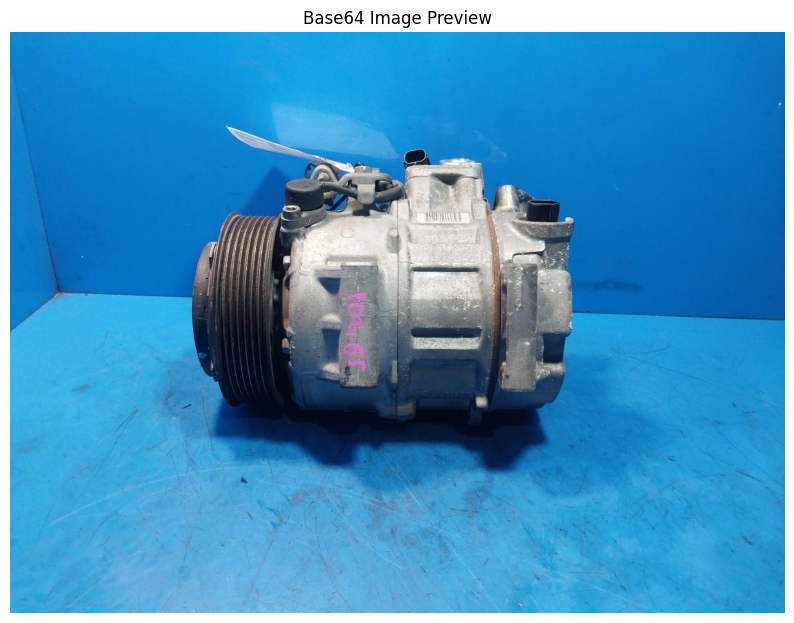

In [18]:
import matplotlib.pyplot as plt
import base64
import io
from PIL import Image

def preview_base64_image(base64_string):
    """
    Preview a Base64 encoded image
    
    Args:
    base64_string (str): Base64 encoded image string
    
    Returns:
    None (displays the image)
    """
    # Remove any prefix like "data:image/png;base64," if present
    if ',' in base64_string:
        base64_string = base64_string.split(',')[1]
    
    try:
        # Decode the Base64 string
        image_bytes = base64.b64decode(base64_string)
        
        # Open the image using Pillow
        image = Image.open(io.BytesIO(image_bytes))
        
        # Create a matplotlib figure
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')  # Hide axes
        plt.title('Base64 Image Preview')
        plt.show()
    
    except Exception as e:
        print(f"Error processing image: {e}")
        
base64_string = res['data']
preview_base64_image(base64_string)